# Imports

In [30]:
!pip install opencv-python

In [31]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

In [2]:
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image data
])

# Load the dataset, it is already split into test and training
train_dataset = ImageFolder('archive/train/', transform=transform)
test_dataset = ImageFolder('archive/test/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
train_dataset[400][0]

tensor([[[ 0.9686,  0.9765,  0.9686,  ...,  0.8353,  0.8353,  0.8745],
         [ 0.9686,  0.9765,  0.9765,  ...,  0.8510,  0.8275,  0.8275],
         [ 0.9765,  0.9608,  0.9451,  ...,  0.7647,  0.8588,  0.8118],
         ...,
         [-0.6000, -0.4275, -0.1922,  ..., -0.0902,  0.6000,  0.7098],
         [-0.6471, -0.3647, -0.1451,  ..., -0.3255,  0.3647,  0.6941],
         [-0.4667, -0.3098, -0.2392,  ..., -0.6706,  0.0667,  0.6235]],

        [[ 0.9686,  0.9765,  0.9686,  ...,  0.8353,  0.8353,  0.8745],
         [ 0.9686,  0.9765,  0.9765,  ...,  0.8510,  0.8275,  0.8275],
         [ 0.9765,  0.9608,  0.9451,  ...,  0.7647,  0.8588,  0.8118],
         ...,
         [-0.6000, -0.4275, -0.1922,  ..., -0.0902,  0.6000,  0.7098],
         [-0.6471, -0.3647, -0.1451,  ..., -0.3255,  0.3647,  0.6941],
         [-0.4667, -0.3098, -0.2392,  ..., -0.6706,  0.0667,  0.6235]],

        [[ 0.9686,  0.9765,  0.9686,  ...,  0.8353,  0.8353,  0.8745],
         [ 0.9686,  0.9765,  0.9765,  ...,  0

# Models

In [4]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


In [215]:
def build_cnn(params):
    # Create an instance of the CNN model
    model = nn.Sequential()
    
    # Extract network parameters from the dictionary
    input_size = params['input_size']
    input_channels = params['input_channels']
    output_channels = params['output_channels']
    kernel_size = params['kernel_size']
    hidden_units = params['hidden_units']
    num_classes = params['num_classes']
    droupout_p = params['dropout']

    # Add the convolutional layers
    for i in range(len(output_channels)):
        if i == 0:
            # First convolutional layer
            model.add_module(f'conv{i}', nn.Conv2d(input_channels, output_channels[i], kernel_size))
        else:
            # Subsequent convolutional layers
            model.add_module(f'conv{i}', nn.Conv2d(output_channels[i-1], output_channels[i], kernel_size))

        # Add the activation function
        model.add_module(f'activation{i}', nn.ReLU())
        
        # Add dropout after the first layer
        if i==0:
            model.add_module(f'drop{i}', nn.Dropout(droupout_p))

        # Add the pooling layer
        if params['max_pooling']:
            model.add_module(f'pooling{i}', nn.MaxPool2d(2))

    # Flatten the feature maps
    model.add_module('flatten', nn.Flatten())

    # Add the fully connected layers
    in_features = input_size
    for i, hidden_units in enumerate(hidden_units):
        model.add_module(f'fc{i}', nn.Linear(in_features, hidden_units))
        model.add_module(f'activation{i+len(output_channels)}', nn.ReLU())
        in_features = hidden_units

    # Add dropout before the output layer
    model.add_module('drop_last', nn.Dropout(droupout_p))
    # Add the output layer
    model.add_module('output', nn.Linear(in_features, num_classes))

    return model

In [6]:

models = {"model1":
          {
            "model": Model1,
            "epochs": 10,
            "learning_rate": 0.001,
            "loss_function": nn.CrossEntropyLoss,
            "optimiser": optim.Adam
          }
}

In [225]:
# Define the network parameters
network_kernels = {"model_k3":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 3,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 512,
                    'max_pooling': True
                  },

                  "model_k5":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True
                  },

                  "model_k6":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 6,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 32,
                    'max_pooling': True
                  }
}

network_params_1 = {"model1":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 3,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 512,
                    'max_pooling': True
                  },

                  "model1_no_pool":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 3,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 56448,
                    'max_pooling': False
                  },

                  "model2":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True
                  },

                  "model2_no_pool":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 41472,
                    'max_pooling': False
                  },

                  "model3":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 6,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 32,
                    'max_pooling': True
                  },

                  "model3_no_pool":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 6,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 34848,
                    'max_pooling': False
                  }  
}

network_params_architecture = {"model_2conv_2hidden":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 2592,
                    'max_pooling': True,
                    "dropout" : 0.0
                  },
                  "model_3conv_2hidden":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.0
                  },
                  "model_4conv_2hidden":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 32,
                    'max_pooling': True,
                    "dropout" : 0.0
                  },
                  "model_3conv_1hidden":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.0
                  },
                  "model_3conv_3hidden":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.0
                  },
                  "model_3conv_4hidden":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128, 128, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.0
                  },
}

network_params = {"model_drop0":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.0
                  },
                  "model_drop01":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.1
                  },
                  "model_drop02":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.2
                  },
                  "model_drop03":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.3
                  },
                  "model_drop05":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.5
                  }
}
network_params_best = {"model_best":
                  {
                    'input_channels': 3,
                    'output_channels': [16, 32, 32],
                    'kernel_size': 5,
                    'hidden_units': [64, 128, 128],
                    'num_classes': 7,
                    'input_size' : 128,
                    'max_pooling': True,
                    "dropout" : 0.1
                  }  
}
# Build the CNN model
models = {}
for mod_name in network_params_best:
    params = network_params_best[mod_name]
    mod = build_cnn(params)
    print(mod)
    models[mod_name] = {
            "model": mod,
            "epochs": 10,
            "learning_rate": 0.001,
            "loss_function": nn.CrossEntropyLoss,
            "optimiser": optim.Adam
    }




Sequential(
  (conv0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (activation0): ReLU()
  (drop0): Dropout(p=0.1, inplace=False)
  (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (activation1): ReLU()
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (activation2): ReLU()
  (pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=128, out_features=64, bias=True)
  (activation3): ReLU()
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (activation4): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (activation5): ReLU()
  (drop_last): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=128, out_features=7, bias=True)
)


# Testing

# Computing metrics

In [21]:
def calculate_metrics(y_true, y_pred):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, average='weighted')
    recall = metrics.recall_score(y_true, y_pred, average='weighted')
    f1_score = metrics.f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1_score

# Training the models

In [226]:
for model_name in models:
   
    model = models[model_name]["model"]
    learning_rate = models[model_name]["learning_rate"]
    epochs = models[model_name]["epochs"]
    loss_function = models[model_name]["loss_function"]()
    optimiser = models[model_name]["optimiser"]

    print(f"Training {model_name}...")

    #model = model()
    
    optimiser = optimiser(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0

        for images, labels in train_loader:

            optimiser.zero_grad()

            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()

            running_loss += loss.item()

        # Evaluation mode
        model.eval()

        # Lists to store predictions and ground truth labels
        all_predictions = []
        all_labels = []

        # Iterate over the test dataset
        for images, labels in test_loader:

            # Forward pass: compute predicted outputs
            outputs = model(images)

            # Get the predicted labels
            _, predictions = torch.max(outputs, 1)

            # Convert predictions and labels to CPU tensors
            predictions = predictions.cpu().numpy()
            labels = labels.cpu().numpy()

            # Store predictions and labels
            all_predictions.extend(predictions)
            all_labels.extend(labels)

        # Compute metrics
        accuracy, precision, recall, f1_score = calculate_metrics(all_labels, all_predictions)

        # Print the metrics
        print(f"Model Name: {model_name}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1_score}\n")

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
        print("\n")

    # Save the trained model
    torch.save(model.state_dict(), f"model_saves/{model_name}.pth")


Training model_best...
Epoch [1/10], Loss: 1.661987800375125


Epoch [2/10], Loss: 1.4160074716421438


Epoch [3/10], Loss: 1.3073152321616897


Epoch [4/10], Loss: 1.2365889812099906


Epoch [5/10], Loss: 1.1871923043626984


Epoch [6/10], Loss: 1.1451414427937803


Epoch [7/10], Loss: 1.1013897785497933


Epoch [8/10], Loss: 1.0629793522684505


Epoch [9/10], Loss: 1.0344480109506833


Epoch [10/10], Loss: 0.9972791738127813




# Assessing the models

In [223]:
for model_name in models:
    
    print(f"Evaluating {model_name}")

    model = models[model_name]["model"]
    #model = model()

    # Load the trained model state dictionary
    model.load_state_dict(torch.load(f"model_saves/{model_name}.pth"))

    # Evaluation mode
    model.eval()

    # Lists to store predictions and ground truth labels
    all_predictions = []
    all_labels = []

    # Iterate over the test dataset
    for images, labels in test_loader:

        # Forward pass: compute predicted outputs
        outputs = model(images)

        # Get the predicted labels
        _, predictions = torch.max(outputs, 1)

        # Convert predictions and labels to CPU tensors
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()

        # Store predictions and labels
        all_predictions.extend(predictions)
        all_labels.extend(labels)

    # Compute metrics
    accuracy, precision, recall, f1_score = calculate_metrics(all_labels, all_predictions)

    # Print the metrics
    print(f"Model Name: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}\n")

Evaluating model_drop0
Model Name: model_drop0
Accuracy: 0.5356645305098914
Precision: 0.5325491253152547
Recall: 0.5356645305098914
F1 Score: 0.5253247137070807

Evaluating model_drop01
Model Name: model_drop01
Accuracy: 0.5356645305098914
Precision: 0.5322305381129473
Recall: 0.5356645305098914
F1 Score: 0.5294248821223652

Evaluating model_drop02
Model Name: model_drop02
Accuracy: 0.5161604903872945
Precision: 0.5214090650004389
Recall: 0.5161604903872945
F1 Score: 0.5106856024424634

Evaluating model_drop03
Model Name: model_drop03
Accuracy: 0.5261911395932014
Precision: 0.5385918088848201
Recall: 0.5261911395932014
F1 Score: 0.5174634023920383

Evaluating model_drop05
Model Name: model_drop05
Accuracy: 0.5345500139314572
Precision: 0.5346125730719405
Recall: 0.5345500139314572
F1 Score: 0.5206458504431059



# Visualising layers

In [207]:
X = torch.tensor(train_dataset[50][0], dtype=torch.float32)
model.eval()
with torch.no_grad():
    feature_maps = model.pooling0((model.conv0(X)))
    feature_maps_2 = model.pooling1(model.conv1(feature_maps))

feature_maps.shape

C:\Users\Test user\AppData\Local\Temp\ipykernel_19904\3449838166.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(train_dataset[50][0], dtype=torch.float32)


torch.Size([16, 22, 22])

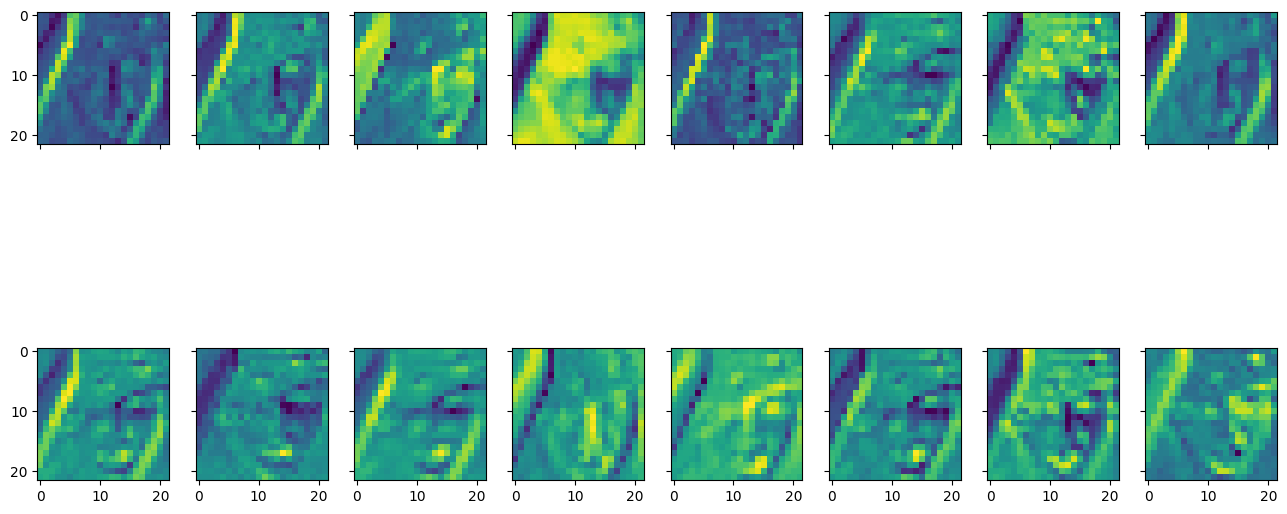

In [208]:

fig, ax = plt.subplots(2, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 16):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[i])
plt.show()

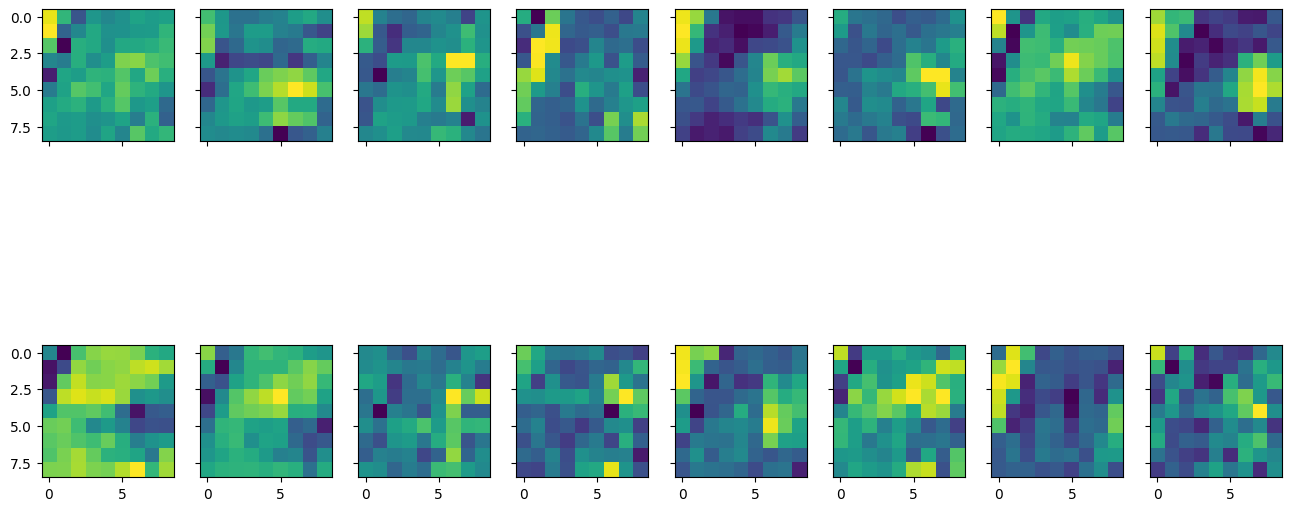

In [210]:

fig, ax = plt.subplots(2, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 16):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps_2[i])
plt.show()

# Testing the CNN

In [32]:
best_model = "model_drop02"

model = models[best_model]["model"]
model.load_state_dict(torch.load(f"model_saves/{best_model}.pth"))
model.eval() 

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.Grayscale(),  # Convert the image to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Only one mean and std for grayscale
])

video_path = 'data/angry.mp4'
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    frame_tensor = torch.from_numpy(frame)  # Convert to Tensor
    frame_tensor = frame_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    frame_tensor = transform(frame_tensor)  


    with torch.no_grad():
        output = model(frame_tensor)

    _, predicted_class = torch.max(output, 1)
    emotion_label = predicted_class.item()
    
    print(emotion_label)

cap.release()
cv2.destroyAllWindows()



ValueError: pic should be 2/3 dimensional. Got 4 dimensions.